In [4]:
%load_ext autoreload
%autoreload 2

from model_utils import train_model, split_data
from config import Config
import json
import matplotlib.pyplot as plt
%matplotlib inline
import math
import random
import os
import datasets
import torch
import transformers
from model_manager import ModelManager

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
seed = random.randint(0, 2 ** 32 - 1)
random.seed(seed)
datasets.logging.set_verbosity(datasets.logging.ERROR)
# Tell pytorch to run this model on the GPU.
device_name = "cuda:0" if torch.cuda.is_available() else "cpu"
# device_name = "cpu"
device = torch.device(device_name)
print(f"Will use {device_name} for training with seed: {seed}")

Will use cuda:0 for training with seed: 914259236


In [6]:
split_data(os.path.join(Config.work_dir, "awsw_story_input.txt"))

In [7]:
config = {
    "model_name": "EleutherAI/gpt-neo-125M",
    "lr": 6e-4,
    "warmup_factor": 0,
    "scheduler": "polynomial_decay_schedule_with_warmup",
    "lr_end": 2e-6,
    "power": 0.6,
    #"freeze_layer_rate": 1e-4,
    "freeze_from_steps": -1,
    "seed": seed,
    "num_epoch": 10,
    "to_freeze_count": 150
}

optuna_result_attachement = {
    'lr': 0.001,
    'scheduler': 'cosine_schedule_with_warmup',
    'to_freeze_count': 150,
    'warmup_factor': 1
}
config.update(optuna_result_attachement)
config

{'model_name': 'EleutherAI/gpt-neo-125M',
 'lr': 0.001,
 'warmup_factor': 1,
 'scheduler': 'cosine_schedule_with_warmup',
 'lr_end': 2e-06,
 'power': 0.6,
 'freeze_from_steps': -1,
 'seed': 914259236,
 'num_epoch': 10,
 'to_freeze_count': 150}

In [8]:
train_results = {}
train_model(config, train_results, device = device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Dataset demo snapshot:
<d><msg>m "At this point, I had difficulties picking up my glass. I was about to give up, but I was sure if I held on just one more round it'd be over. I could still win this. I had to wait a few moments after each sip in order to continue, but I did not give up until, eventually, the glass was empty."<p><msg>c"S-Suck on this, you ssscaly bastard."<d><msg>m "At this point, I had difficulties picking up my glass. I was about to give up, but I
 was sure if I held on just one more round it'd be over. I could still win this. I had to wait a few moments after each sip in order to continue, but I did not give up until, eventually, the glass was empty."<p><msg>c"S-Suck on this, you ssscaly bastard."<|endoftext|><p><msg>c "Go ahead and turn it on, then."<d><msg>Sb "Would you stand between the pillars, please?"<|endoftext|><p><msg>c "You too."<d><msg>Lo "Hey, [player
[0] set freeze_part_layers: True (freezing 150 out of 160 layers.)


Step,Training Loss
4,3.582400
8,3.426300
12,3.249700
16,2.945900
20,2.759800
24,2.693400
28,2.665400
32,2.558600
36,2.523300
40,2.367000


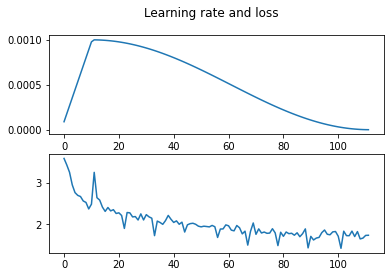

In [9]:
fig, axs = plt.subplots(2)
fig.suptitle('Learning rate and loss')
axs[0].plot(train_results['learning_rate_history'])
axs[1].plot(train_results['loss_history'])

# Testing

We created a few past (for context) + present prompts (player input) and see the different reactions. This way, we can test the models across different iterations.

In [10]:
train_results['model'].eval()
model_manager = ModelManager(model=train_results['model'], tokenizer=train_results['tokenizer'])

In [11]:
prompts = [
    ('msg p c "Hey Remy!" msg d Ry "Hey!"', "How are you?"),
    ('msg p c "I was with Lorem today." msg d Ad "Very nice."', "What do you think of Lorem?"),
    ('msg d m "In Tatsu park, Adine and I sat down."', "Oh my god, Adine. What is this?"),
    ('msg d m "I sat down on a chair in Anna\'s lab."', "What will we do here?"),
]

for (past, prompt) in prompts:
    reply = model_manager.say(past, prompt)
    print(f"Prompt: {prompt}\nReply: {reply}\n\n")

Prompt: How are you?
Reply: Ry "I'm fine."<d><msg>Ry "I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm fine. I'm


Prompt: What do you think of Lorem?
Reply: Ad "I think I'll just leave now."<d><msg>Ad "I think I'll just leave now."<p><msg>c"<|endoftext|>


Prompt: Oh my god, Adine. What is this?
Reply: Ad "I'm not sure, but I think it's a sign."<d><msg>Ad "I'm not sure, but I think it's a sign."<d><msg>Ad "I'm not sure, but I think it's a sign."<d><msg>Ad "I'm not sure, but I think it's a sign."<d><msg>Ad "I'm not sure, but I think it's a


Prompt: What will we do here?
Reply: Ry "I'll just take a seat on the other side of the table."<d><msg>Ry "I'll just take a seat on the other side of the table."<d><msg>Ry "I'll just take a seat on the other side of the table."<d><msg>Ry "I'll just take a seat on the other side of the t

# Sampling test

Which combination is the best?

In [ ]:
for i in range(100):
    torch.manual_seed(80085)
    top_k = random.randint(0, 100)
    top_p = round(random.uniform(0, 1), 2)
    for (past, prompt) in prompts:
        reply = model_manager.say(past, prompt, top_k = top_k, top_p = top_p)
        print(f"[Test {i + 1} top_k: {top_k}, top_p: {top_p}] -> Prompt: {prompt}\nReply: {reply}\n")
    print("-------------")

[Test 1 top_k: 33, top_p: 0.75] -> Prompt: How are you?
Reply: Ry "I'm fine."<p><msg>c"I'm fine."<d><msg>Ry "Heavier was fine, though."<d><msg>Ry "Heavier was fine, though."<|endoftext|>

[Test 1 top_k: 33, top_p: 0.75] -> Prompt: What do you think of Lorem?
Reply: Ad "He was the one who said we should talk about Reza."<d><msg>Ad "It was him who told me to meet here."<p><msg>c" "I don't know."<d><msg>Ad "He told me to meet here, Lorem."<p><msg>c" "I didn't want to meet here. I just wanted to meet Lorem."<d><msg>Ad "You

[Test 1 top_k: 33, top_p: 0.75] -> Prompt: Oh my god, Adine. What is this?
Reply: Ad "I'm a dragon, you know. My turn."<d><msg>Ad "Oh my god, Adine."<d><msg>Ad "Well, I guess it's a long story."<d><msg>Ad "Well, I guess it's a long story. Guess it's a long story. Guess it's a long story."<d><msg>Ad "Well, guess it's a long story. Guess it

[Test 1 top_k: 33, top_p: 0.75] -> Prompt: What will we do here?
Reply: Ry "I'll just have a quiet chuckle and just go about my busi

In [ ]:
print("What to say?")
print(generate_dragon_reply("", input()))